# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [89]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

def print3D(x, y, z=None, c='b'):
    if z is None:
        plt.scatter(x,y, c=c)
    else:
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(x, y, z, c=c)

**Сгенирирум данные**

In [47]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

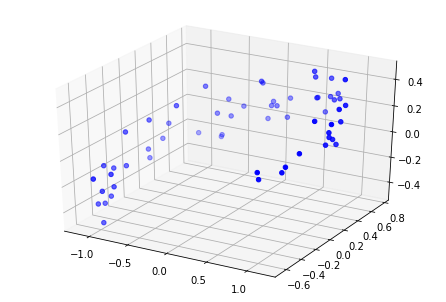

In [90]:
print3D(X[:, 0], X[:, 1], X[:, 2])

# PCA

## Introduce PCA

[0.93636116 0.29854881 0.18465208]
[-0.34027485  0.90119108  0.2684542 ]


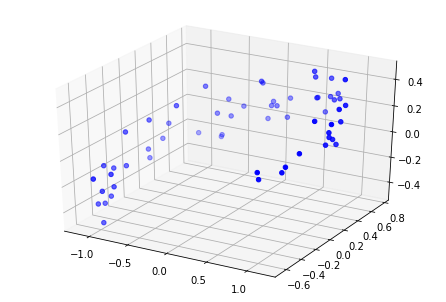

In [99]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

print3D(X[:, 0], X[:, 1], X[:, 2])
print(c1)
print(c2)

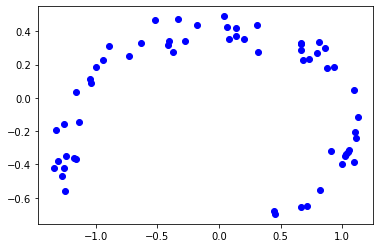

In [97]:
W2 = Vt[:2].T
X2D = np.matmul(X_centered, W2)
print3D(X2D[:, 0], X2D[:, 1])

## PCA in SKLean

pca principal components:
 [[-0.93636116 -0.29854881 -0.18465208]
 [ 0.34027485 -0.90119108 -0.2684542 ]]
principal components calculated manually:
 [[ 0.93636116  0.29854881  0.18465208]
 [-0.34027485  0.90119108  0.2684542 ]]


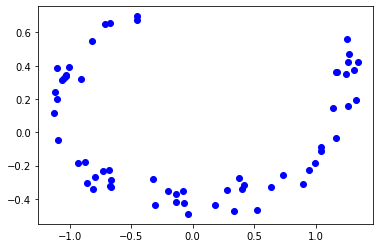

In [98]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)
print3D(X2D[:, 0], X2D[:, 1])

print("pca principal components:\n", pca.components_)
print("principal components calculated manually:\n", W2.T)

Визуально результат такой же как и в предыдущем методе. Вектор pc отличается только направлением (что визуально можно наблюдать)

In [100]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])